In [2]:
import pandas as pd
import numpy as np
import torch
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import nltk
import random
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm


from nltk.tokenize import word_tokenize
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from torch.utils.data import DataLoader, Dataset
from collections import Counter

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
df_train = pd.read_csv('/kaggle/input/a4-dataset/train.csv')
df_test = pd.read_csv('/kaggle/input/a4-dataset/test.csv')

df_train = df_train.iloc[:20000].reset_index(drop=True)

In [5]:
df_train.to_csv('train_20k.csv', index=False)

In [9]:
class CustomDataset(Dataset):
    def __init__(self, data, flag):
        self.data = data
        self.tokens = [self.word_tokenizer(doc) for doc in self.data['Description']]
        self.vocab = self.build_vocab(flag)
        self.padding()

    def build_vocab(self, checkFlag):
        if checkFlag == 1:
            vocab = set()
            for tokens in tqdm(self.tokens, total=len(self.tokens)):
                for token in tokens:
                    vocab.add(token)

            vocab = {word: i for i, word in enumerate(vocab, start=1)}
            vocab['<unk>'] = 0

            return vocab
        else:
            vocab = train_data.vocab
            return vocab

    def word_tokenizer(self, sentence):
        tokens = word_tokenize(sentence)
        tokens = [token.lower() for token in tokens]
        return ['<start>'] + tokens + ['<end>']
    
    def convert_to_tensor(self, sentence):
        return torch.tensor([self.vocab[word] if word in self.vocab else self.vocab['<unk>'] for word in sentence])

    def padding(self):
        self.tokens = [self.convert_to_tensor(doc) for doc in self.tokens]
        self.padded_sequences = pad_sequence(self.tokens, batch_first=True, padding_value=len(self.vocab))
        self.classes = np.unique(self.data['Class Index'])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        label = self.data.loc[idx, 'Class Index']
        tokens = self.padded_sequences[idx]
        return tokens, torch.tensor(label, dtype=torch.int64)


In [7]:
train_data = CustomDataset(df_train, flag=1)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

100%|██████████| 20000/20000 [00:00<00:00, 148980.37it/s]


In [ ]:
import pickle

# Save
with open('train_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)

In [ ]:
with open('test_data.pkl', 'wb') as f:
    pickle.dump(test_data, f)

In [8]:
test_data = CustomDataset(df_test, flag=0)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [13]:
class ELMo(nn.Module):
    def __init__(self, vocab_size, e_dim, h_dim):
        super(ELMo, self).__init__()
        self.vocab_size = vocab_size
        self.e_dim = e_dim
        self.h_dim = h_dim
        self.pad_token = torch.tensor(self.vocab_size)
        self.embedding = nn.Embedding(self.vocab_size + 1, self.e_dim, padding_idx=self.vocab_size)

        # forward and backward LSTMs for the first layer
        self.lstm_for1 = nn.LSTM(self.e_dim, self.h_dim, batch_first=True)
        self.lstm_for2 = nn.LSTM(self.h_dim, self.h_dim, batch_first=True)

        # forward and backward LSTMs for the second layer
        self.lstm_back1 = nn.LSTM(self.e_dim, self.h_dim, batch_first=True)
        self.lstm_back2 = nn.LSTM(self.h_dim, self.h_dim, batch_first=True)

        # embedding layer for combining layer outputs
        self.weights = nn.Embedding(1, 3)
        self.weights.weight = nn.Parameter(torch.ones(1, 3) / 3, requires_grad=True)

        # padding
        self.end_padding = torch.zeros(self.h_dim, requires_grad=False).unsqueeze(0).unsqueeze(0).to(device)
        self.linear = nn.Linear(2 * self.h_dim, self.vocab_size)
    
    def for_output(self, x, x_rev):
        # Embed the input sequences
        forward = self.embedding(x)
        reverse = self.embedding(x_rev)

        # first layer LSTMs
        lstm1_out_forward, _ = self.lstm_for1(forward)
        lstm2_out_forward, _ = self.lstm_for2(lstm1_out_forward)
        
        # second layer LSTMs
        lstm1_out_backward, _ = self.lstm_back1(reverse)
        lstm1_out_backward = lstm1_out_backward.flip(1)
        lstm2_out_backward, _ = self.lstm_back2(lstm1_out_backward)
        lstm2_out_backward = lstm2_out_backward.flip(1)

        return lstm1_out_forward, lstm1_out_backward, lstm2_out_forward, lstm2_out_backward, forward

    def pad(self, fwd, bwd, output_padding, padding_indices):
        fwd = torch.cat((output_padding, fwd), dim=1)
        bwd = torch.cat((bwd, output_padding, output_padding), dim=1)
        bwd[torch.arange(len(fwd)).to(device), padding_indices, :] = torch.zeros(len(fwd), bwd.shape[2]).to(device)
        return torch.cat((fwd, bwd[:, 1:]), dim=2)

    def forward(self, x):
        x_rev = x.flip(1)
        padding_indices = torch.sum(x != self.pad_token, dim=1).to(device)

        lstm1_fwd, lstm1_bwd, lstm2_fwd, lstm2_bwd, forward = self.for_output(x, x_rev)

        # Prepare padding for layer outputs
        output_padding = self.end_padding.expand(lstm2_fwd.shape[0], 1, lstm2_fwd.shape[2])

        # Padding and concatenation for second layer outputs
        lstm2_out = self.pad(lstm2_fwd, lstm2_bwd, output_padding, padding_indices)
        lstm1_out = self.pad(lstm1_fwd, lstm1_bwd, output_padding, padding_indices)

        # Weighted sum of layer outputs and embeddings
        norm = self.weights(torch.zeros(1).long().to(device)) 
        weighted_output = norm[0, 0] * lstm1_out + norm[0, 1] * lstm2_out + norm[0, 2] * torch.cat((torch.cat((output_padding, output_padding), dim=2), forward), dim=1)

        output_probs = self.linear(weighted_output)
        return output_probs[:, :-1, :]
    
    def pretrain(self, train_loader, learning_rate=0.01, num_epochs=10):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss(ignore_index = self.vocab_size)
        
        for epoch in range(num_epochs):
            self.train()
            train_loss = 0
            for i, (input, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
                optimizer.zero_grad()
                input = input.to(device)
                outputs = self(input)
                loss = criterion(outputs.reshape(-1, outputs.size(2)), input.view(-1))
                train_loss += loss.item()
                loss.backward()
                optimizer.step()
            print(f"Epoch {epoch}, Train loss: {train_loss / len(train_loader)}")
        
    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        self.load_state_dict(torch.load(path))
        
    def generate_embeddings(self, x_f):
        x_rev = x_f.flip(1).to(x_f.device)  # Ensure x_rev is on the same device as x_f
        lstm1_out_forward, lstm1_out_backward, lstm2_out_forward, lstm2_out_backward, forward = self.for_output(x_f, x_rev)
        lstm1_out = torch.cat((lstm1_out_forward, lstm1_out_backward), dim=2)
        lstm2_out = torch.cat((lstm2_out_forward, lstm2_out_backward), dim=2)

        return lstm1_out, lstm2_out, forward


In [10]:
vocab = train_data.vocab
vocab_size = len(vocab)
h_dim = 128
e_dim = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

elmo_model = ELMo(vocab_size, e_dim, h_dim).to(device)
elmo_model.pretrain(train_loader, num_epochs=10)
# elmo_model.evaluate_model(test_loader)

100%|██████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch 0, Train loss: 6.465715045746142


100%|██████████| 313/313 [01:09<00:00,  4.48it/s]


Epoch 1, Train loss: 4.8646961035439


100%|██████████| 313/313 [01:09<00:00,  4.48it/s]


Epoch 2, Train loss: 4.1412699374908835


100%|██████████| 313/313 [01:09<00:00,  4.48it/s]


Epoch 3, Train loss: 3.613151142772394


100%|██████████| 313/313 [01:09<00:00,  4.47it/s]


Epoch 4, Train loss: 3.1842249132954654


100%|██████████| 313/313 [01:09<00:00,  4.47it/s]


Epoch 5, Train loss: 2.823026369174068


100%|██████████| 313/313 [01:09<00:00,  4.47it/s]


Epoch 6, Train loss: 2.5164107750779903


100%|██████████| 313/313 [01:09<00:00,  4.47it/s]


Epoch 7, Train loss: 2.2572850571653715


100%|██████████| 313/313 [01:09<00:00,  4.47it/s]


Epoch 8, Train loss: 2.0363629595540202


100%|██████████| 313/313 [01:09<00:00,  4.47it/s]

Epoch 9, Train loss: 1.847055717017323


In [11]:
elmo_model.eval()
with torch.no_grad():
  acc = 0
  for x_f, l in tqdm(test_loader, desc = "Testing"):
      x_f = x_f.to(device)
      outputs = elmo_model(x_f.to(device))
      predicted = torch.argmax(outputs, dim = 2).view(-1)
      actual = x_f.view(-1)
      pad_indices = actual == vocab_size
      count_pads = torch.sum(pad_indices)
      predicted[pad_indices] = vocab_size
      acc += (torch.sum(predicted == actual) - count_pads) / (len(actual) - count_pads)

print(f"Test Accuracy: {acc / len(test_loader):.4f}")

Testing: 100%|██████████| 119/119 [00:05<00:00, 22.10it/s]

Test Accuracy: 0.4121


In [12]:
elmo_model.save_model('bilstm.pt')

In [19]:
class LSTMClassifier(nn.Module):
    def __init__(self, elmo_model, h_dim, e_dim, classes, combine='trainable'):
        super(LSTMClassifier, self).__init__()
        self.elmo_model = elmo_model
        self.h_dim = h_dim
        self.classes = classes
        self.h_dim = h_dim
        self.e_dim = e_dim
        self.combine = combine
        
        for param in self.elmo_model.parameters():
            param.requires_grad = False
        
        self.lstm = nn.LSTM(input_size=self.e_dim, hidden_size=self.h_dim, batch_first=True)        
        self.output_layer = nn.Linear(self.h_dim, classes)

        if combine == 'trainable':
            self.embedding_weights = nn.Parameter(torch.ones(3) / 3)
        elif combine == 'frozen':
            self.embedding_weights = torch.randn(3, requires_grad=False)
        elif combine == 'function':
            self.layer = nn.Sequential(
                nn.Linear(3*self.e_dim, self.e_dim), nn.ReLU())
        else:
            print("Incorrect option")
            return
        
    def forward(self, X, classification='mean'):
        lstm1, lstm2, embedding_layer = elmo_model.generate_embeddings(X)

        embedding_types = ['trainable', 'frozen']
        if self.combine in embedding_types:
            input = sum(self.embedding_weights[i] * layer for i, layer in enumerate([lstm1, lstm2, embedding_layer]))
        else:
            input = self.layer(torch.cat((lstm1,lstm2,embedding_layer), dim = 2))
        
        output, _ = self.lstm(input)
        lengths = (X != vocab_size).sum(dim=1)
        
        hidden_states = [output[idx, lengths[idx] - 1].unsqueeze(0) if classification == 'last' else torch.mean(output[idx, 0:lengths[idx]], dim=0).unsqueeze(0) for idx, _ in enumerate(X)]
        hidden_states = torch.cat(hidden_states, dim=0)
        final = self.output_layer(hidden_states)
        
        return final
    
    def train_model(self, train_loader, classification="mean", num_epochs=10, learning_rate=0.01):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            self.train()
            train_loss = 0
            for input, target in tqdm(train_loader, total=len(train_loader)):
                optimizer.zero_grad()
                input = input.to(device)
                target = target.to(device)
                
                outputs = model(input,classification)
                # classes are 1, 2, 3, 4 (prediction will be 0, 1, 2, 3)
                loss = criterion(outputs, target-1)
                train_loss += loss.item()
                loss.backward()
                optimizer.step()
                
            print(f"Epoch {epoch}, Train loss: {train_loss / len(train_loader)}")

    def evaluate_model(self, eval_loader, flag=0):
        self.eval()

        all_labels = []
        all_predictions = []

        with torch.no_grad():  # No need to track gradients
            for input_batch, output_batch in eval_loader:
                input_batch = input_batch.to(device)
                output_batch = output_batch.to(device)
                output_batch -= 1

                outputs = self(input_batch)
                _, predicted = torch.max(outputs, 1)

                all_labels.extend(output_batch.tolist())
                all_predictions.extend(predicted.tolist())

        accuracy = accuracy_score(all_labels, all_predictions)
        f1_micro = f1_score(all_labels, all_predictions, average='micro')
        f1_macro = f1_score(all_labels, all_predictions, average='macro')
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')

        print("Accuracy: ", accuracy)
        print("F1 Macro: ", f1_micro)
        print("F1 Micro: ", f1_macro)
        print("Precision: ", precision)
        print("Recall: ", recall)

        if flag == 1:
            cm = confusion_matrix(all_labels, all_predictions)
            class_names = [1, 2, 3, 4]

            plt.figure(figsize=(10,10))
            sns.heatmap(cm, annot=True, square=True, fmt='d', cmap='Blues', 
                        xticklabels=class_names, yticklabels=class_names)

            plt.title('Confusion Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
            
        return accuracy, f1_micro, f1_macro, precision, recall
    
    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        self.load_state_dict(torch.load(path))


trainable



100%|██████████| 313/313 [00:13<00:00, 23.89it/s]


Epoch 0, Train loss: 0.5359788729836004


100%|██████████| 313/313 [00:13<00:00, 23.97it/s]


Epoch 1, Train loss: 0.34094428454344267


100%|██████████| 313/313 [00:13<00:00, 23.92it/s]


Epoch 2, Train loss: 0.22285529930656328


100%|██████████| 313/313 [00:13<00:00, 23.96it/s]


Epoch 3, Train loss: 0.15491834574471267


100%|██████████| 313/313 [00:13<00:00, 23.92it/s]


Epoch 4, Train loss: 0.12772609509480076


100%|██████████| 313/313 [00:13<00:00, 23.96it/s]


Epoch 5, Train loss: 0.12217344146090955


100%|██████████| 313/313 [00:13<00:00, 23.93it/s]


Epoch 6, Train loss: 0.08914848959769685


100%|██████████| 313/313 [00:13<00:00, 23.95it/s]


Epoch 7, Train loss: 0.08564946303566615


100%|██████████| 313/313 [00:13<00:00, 23.99it/s]


Epoch 8, Train loss: 0.10114491603875789


100%|██████████| 313/313 [00:13<00:00, 23.93it/s]


Epoch 9, Train loss: 0.10686230805282966
TRAIN EVALUATION
Accuracy:  0.97785
F1 Macro:  0.97785
F1 Micro:  0.9778343345774022
Precision:  0.9778702721942718
Recall:  0.97785


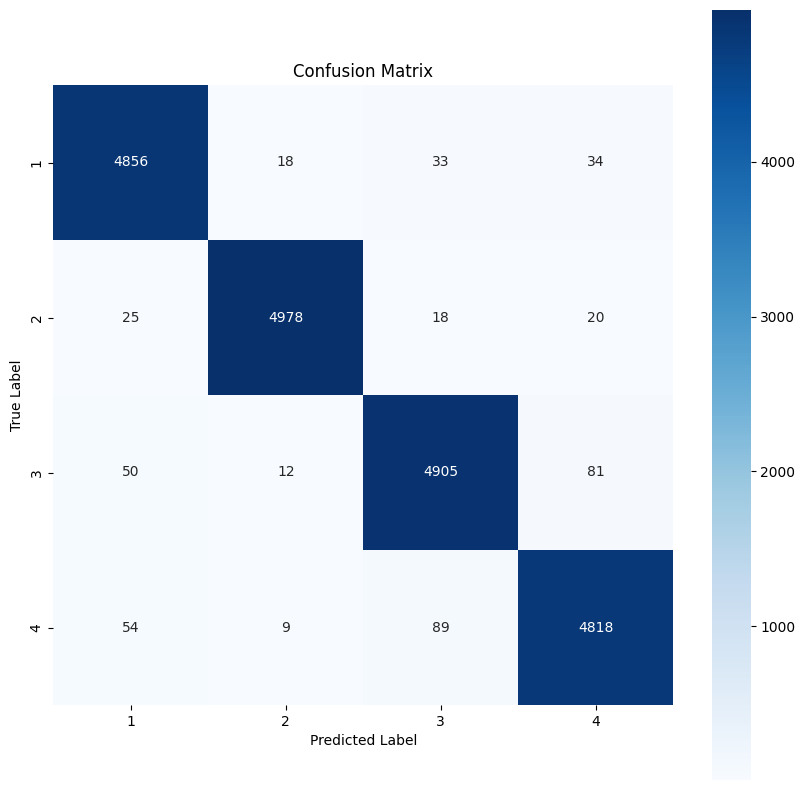

TEST EVALUATION
Accuracy:  0.8111842105263158
F1 Macro:  0.8111842105263158
F1 Micro:  0.8127226388550949
Precision:  0.8160439779831752
Recall:  0.8111842105263158


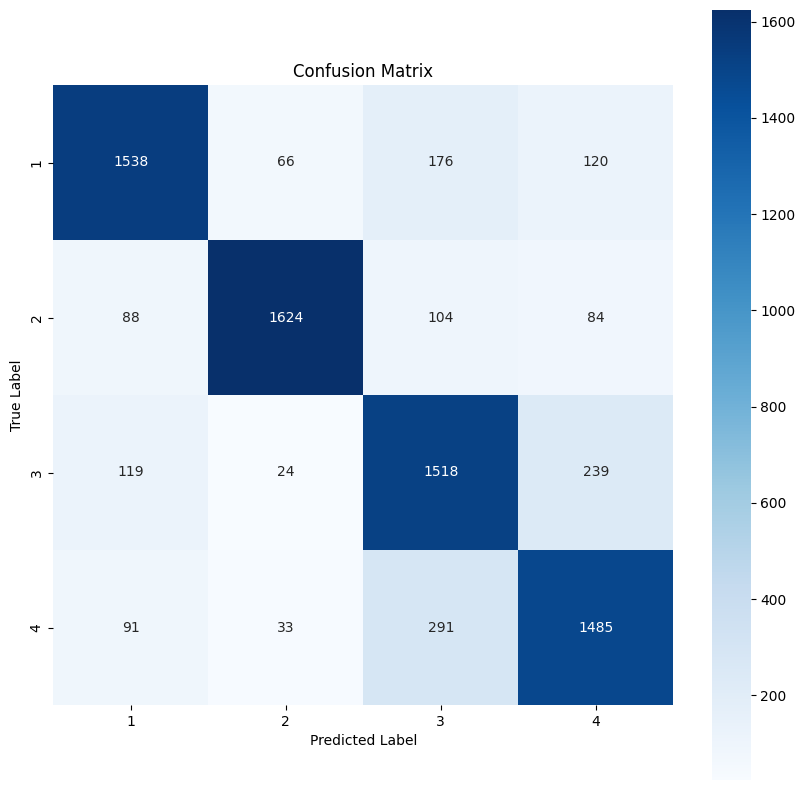

frozen



100%|██████████| 313/313 [00:13<00:00, 24.06it/s]


Epoch 0, Train loss: 0.6349881520857826


100%|██████████| 313/313 [00:13<00:00, 24.07it/s]


Epoch 1, Train loss: 0.5849829866482427


100%|██████████| 313/313 [00:13<00:00, 24.05it/s]


Epoch 2, Train loss: 0.5519737256601596


100%|██████████| 313/313 [00:13<00:00, 24.01it/s]


Epoch 3, Train loss: 0.5439317097869544


100%|██████████| 313/313 [00:13<00:00, 24.05it/s]


Epoch 4, Train loss: 0.5196412736996294


100%|██████████| 313/313 [00:13<00:00, 24.04it/s]


Epoch 5, Train loss: 0.4961615601858011


100%|██████████| 313/313 [00:13<00:00, 24.03it/s]


Epoch 6, Train loss: 0.4922063059795398


100%|██████████| 313/313 [00:13<00:00, 24.07it/s]


Epoch 7, Train loss: 0.4704006811776481


100%|██████████| 313/313 [00:13<00:00, 24.05it/s]


Epoch 8, Train loss: 0.4566500560163309


100%|██████████| 313/313 [00:13<00:00, 24.06it/s]


Epoch 9, Train loss: 0.4465819974296009
TRAIN EVALUATION
Accuracy:  0.84425
F1 Macro:  0.8442500000000001
F1 Micro:  0.8430337729300778
Precision:  0.8439064721829552
Recall:  0.84425


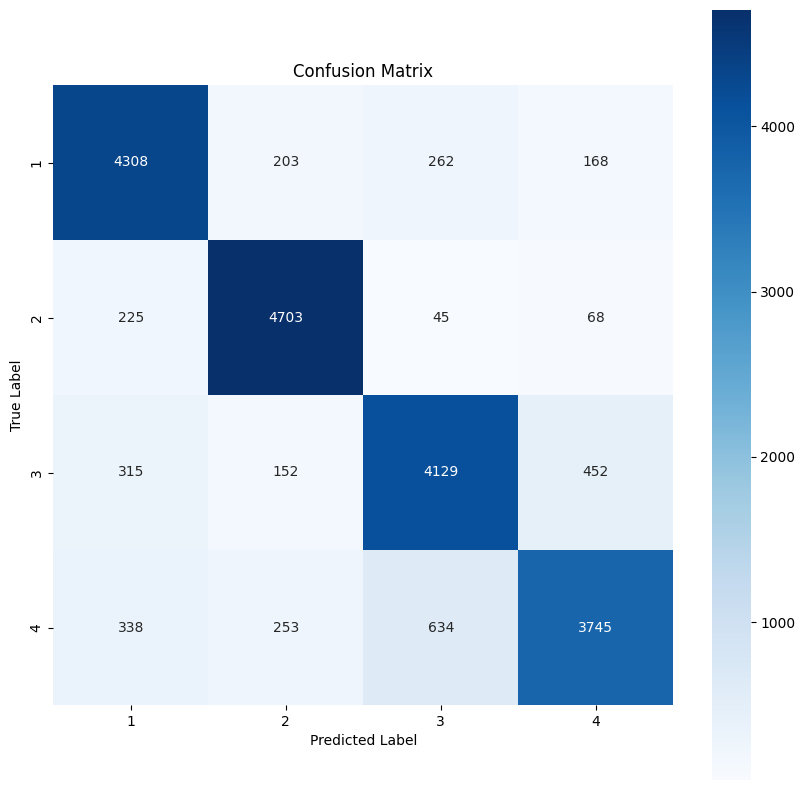

TEST EVALUATION
Accuracy:  0.7725
F1 Macro:  0.7725000000000001
F1 Micro:  0.772685028206847
Precision:  0.7741427037506997
Recall:  0.7725


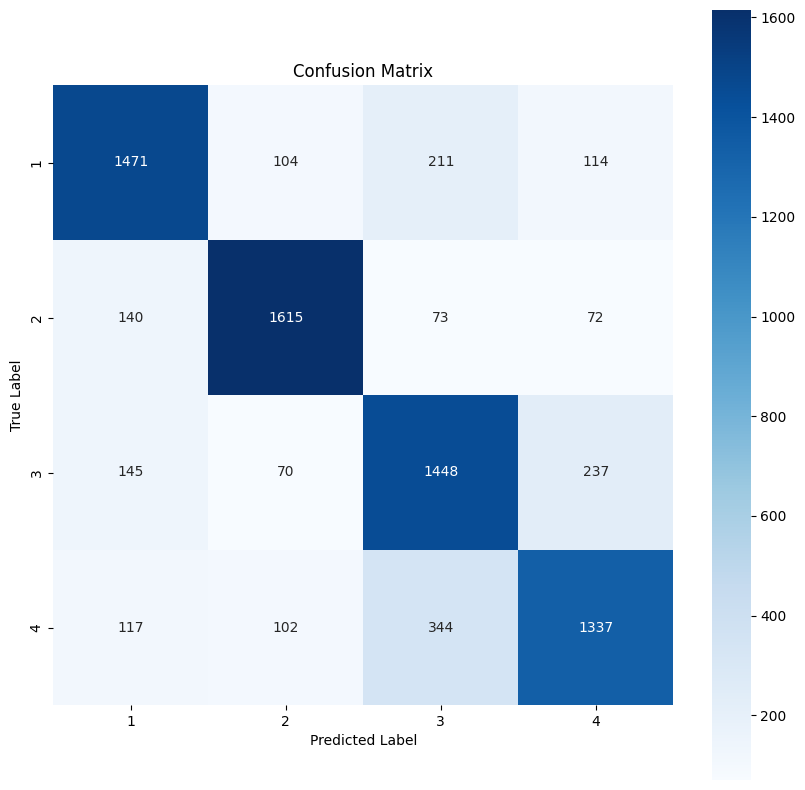

function



100%|██████████| 313/313 [00:13<00:00, 23.12it/s]


Epoch 0, Train loss: 0.6417404506534052


100%|██████████| 313/313 [00:13<00:00, 23.13it/s]


Epoch 1, Train loss: 0.4865944453607352


100%|██████████| 313/313 [00:13<00:00, 23.08it/s]


Epoch 2, Train loss: 0.41491595781839696


100%|██████████| 313/313 [00:13<00:00, 22.97it/s]


Epoch 3, Train loss: 0.3593933407110147


100%|██████████| 313/313 [00:13<00:00, 23.03it/s]


Epoch 4, Train loss: 0.3276209678893653


100%|██████████| 313/313 [00:13<00:00, 23.07it/s]


Epoch 5, Train loss: 0.2910011300263694


100%|██████████| 313/313 [00:13<00:00, 23.05it/s]


Epoch 6, Train loss: 0.2686715007256776


100%|██████████| 313/313 [00:13<00:00, 23.07it/s]


Epoch 7, Train loss: 0.24751697813931364


100%|██████████| 313/313 [00:13<00:00, 23.10it/s]


Epoch 8, Train loss: 0.23788979742378472


100%|██████████| 313/313 [00:13<00:00, 23.08it/s]


Epoch 9, Train loss: 0.21412618618946486
TRAIN EVALUATION
Accuracy:  0.9192
F1 Macro:  0.9192
F1 Micro:  0.919388147592701
Precision:  0.9280140285856567
Recall:  0.9192


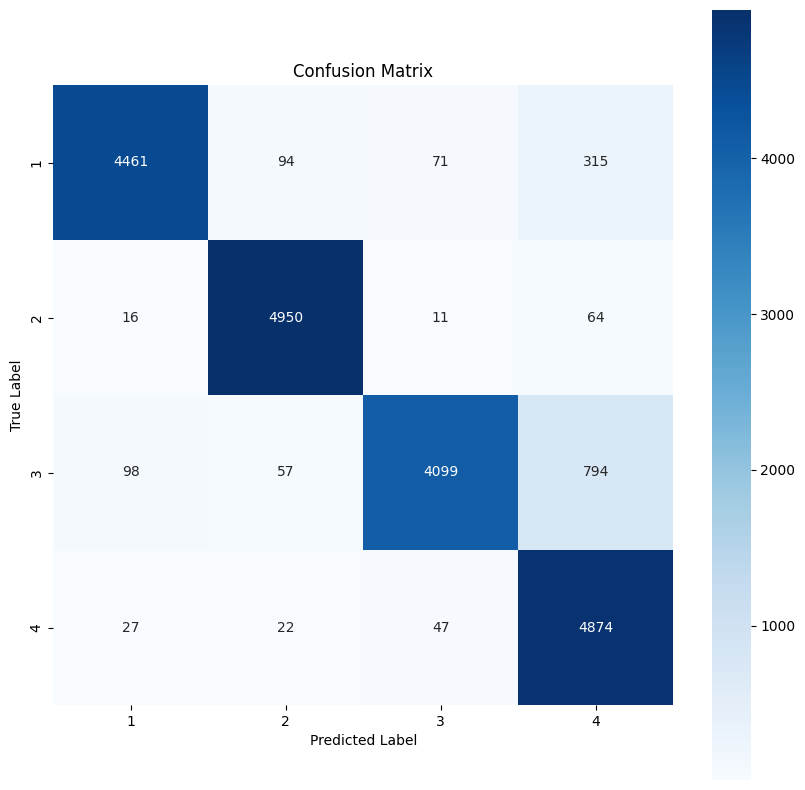

TEST EVALUATION
Accuracy:  0.8139473684210526
F1 Macro:  0.8139473684210526
F1 Micro:  0.8151832655259477
Precision:  0.8303913595927429
Recall:  0.8139473684210526


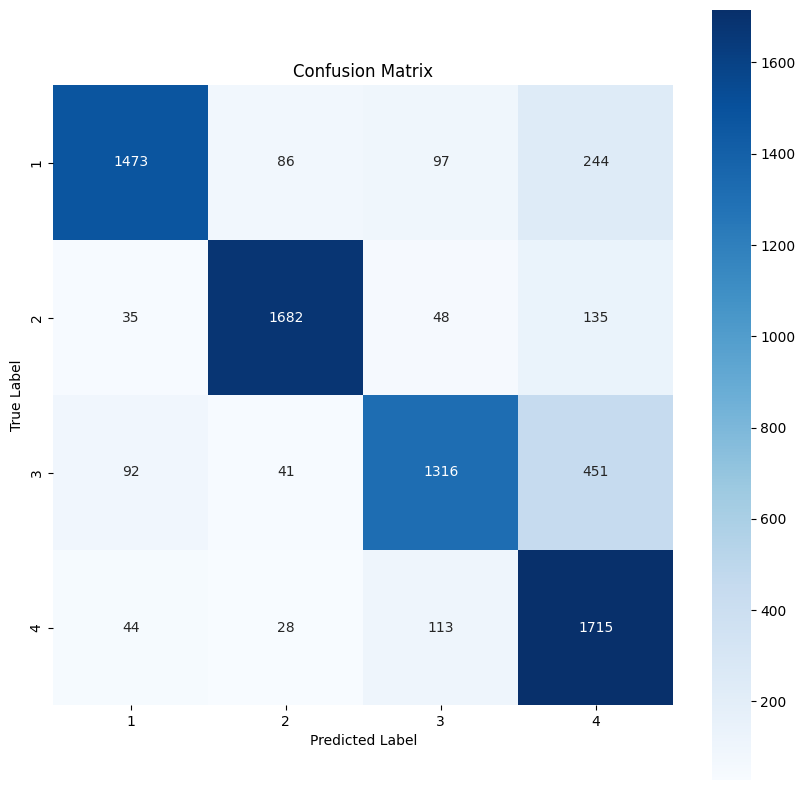

In [21]:
combine = ['trainable', 'frozen', 'function']

# Initialize best accuracy to 0
best_accuracy = 0
best_model_path = ""

for emb in combine:
    print(emb)
    print()
    model = LSTMClassifier(elmo_model, 256, e_dim, 4, emb).to(device)
    model.train_model(train_loader)
    
    print("TRAIN EVALUATION")
    accuracy, f1_micro, f1_macro, precision, recall = model.evaluate_model(train_loader, flag = 1)
    
    print("TEST EVALUATION")
    accuracy, f1_micro, f1_macro, precision, recall = model.evaluate_model(test_loader, flag = 1)
    name = 'classifier_' + emb + '.pt'
    model.save_model(name)

    # If the current model's accuracy is better than the best accuracy
    if accuracy > best_accuracy:
        # Update best accuracy and best model path
        best_accuracy = accuracy
        best_model_path = name


In [22]:
print("Best Model Path:", best_model_path)
print("Best Model Accuracy:", best_accuracy)

Best Model Path: classifier_function.pt
Best Model Accuracy: 0.8139473684210526
